# ID3算法实现过程

In [1]:
import pandas as pd 
import numpy as np
import math

### 创建数据集

In [2]:
def createDataSet():
    data = pd.read_excel("C:\\Users\\ms\\Desktop\\dataSet.xlsx",sheet_name="Sheet1" )
    # 删除多余没有优化的列
    data = data.drop('ID',axis=1)
    #标签
    labels = list(data.columns)
    #数据集
    dataSet = data.values
    return dataSet, labels

In [3]:
dataSet, labels = createDataSet()

In [6]:
print(dataSet)
print('------------------------------')
print(labels)

[['青年' '否' '否' '一般' '否']
 ['青年' '否' '否' '好' '否']
 ['青年' '是' '否' '好' '是']
 ['青年' '是' '是' '一般' '是']
 ['青年' '否' '否' '一般' '否']
 ['中年' '否' '否' '一般' '否']
 ['中年' '否' '否' '好' '否']
 ['中年' '是' '是' '好' '是']
 ['中年' '否' '是' '非常好' '是']
 ['中年' '否' '是' '非常好' '是']
 ['老年' '否' '是' '非常好' '是']
 ['老年' '否' '是' '好' '是']
 ['老年' '是' '否' '好' '是']
 ['老年' '是' '否' '非常好' '是']
 ['老年' '否' '否' '一般' '否']]
------------------------------
['年龄', '工作', '房子', '信贷情况', '类别']


### 根据特征分割数据集

In [7]:
def splitDataSet(dataSet,axis,value):
    """
    按照给定特征划分数据集
    :param axis:划分数据集的特征的维度
    :param value:特征的值
    :return: 符合该特征的所有实例（并且自动移除掉这维特征）
    """

    # 循环遍历dataSet中的每一行数据
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = list(featVec[:axis]) # 删除这一维值为value的特征
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet

In [8]:
#测试
splitDataSet(dataSet,0,'青年')

[['否', '否', '一般', '否'],
 ['否', '否', '好', '否'],
 ['是', '否', '好', '是'],
 ['是', '是', '一般', '是'],
 ['否', '否', '一般', '否']]

### 计算信息熵

In [9]:
# 计算的始终是类别标签的不确定度
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)    #数据集的大小
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]    # 类别标签在最后一列
        # 映射成字典： {'否': 6, '是': 9}
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 1
        else:
            labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    # 计算熵
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt = shannonEnt - prob * math.log(prob,2)
    return shannonEnt

In [10]:
#测试
calcShannonEnt(dataSet)

0.9709505944546686

### 计算条件熵



In [11]:
def calcConditionalEnt(dataSet,i,uniqueVals):
    
    """
    计算x_i给定的条件下，Y的条件熵
    :param dataSet: 数据集
    :param i: 维度i
    :param unqiueVals: 数据集特征集合
    :return: 条件熵  
    """
    ce = 0.0
    for val in uniqueVals:
        subDataSet = splitDataSet(dataSet,i,val)
        # 极大似然估计概率
        prob = len(subDataSet) / float(len(dataSet))
        #∑pH(Y|X=xi) 条件熵的计算 
        ce = ce + prob * calcShannonEnt(subDataSet)
    return ce

In [12]:
# 测试
calcConditionalEnt(dataSet,2,uniqueVals=['是','否'])

0.5509775004326937

### 计算信息增益

In [13]:
def calcGain(dataSet,i):
    """
    计算信息增益
    :param dataSet: 数据集
    :param baseEntropy: 数据集中Y的信息熵
    :param i: 特征维度i
    :return: 特征i对数据集的信息增益g(dataSet | X_i)
    """
    featList = [example[i] for example in dataSet] # 第i维特征列表
    uniqueVals = set(featList) # 换成集合 - 集合中的每个元素不重复
    newEntropy = calcConditionalEnt(dataSet,i,uniqueVals)
    baseEntropy = calcShannonEnt(dataSet)
    inforGain = baseEntropy - newEntropy # 信息增益
    return inforGain

In [14]:
# 测试
for i in range(len(labels)-1):
    print(calcGain(dataSet,i))

0.08300749985576883
0.32365019815155627
0.4199730940219749
0.36298956253708536


## 算法骨架

In [15]:
def chooseBestFeatureToSplitByID3(dataSet):
    """
    选择最好的数据集划分
    :param dataSet:
    :return:
    """
    numFeatures = len(dataSet[0]) -1 # 最后一列是分类
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures): # 遍历所有维度特征
        infoGain = calcGain(dataSet,i)
        if infoGain > bestInfoGain :
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature # 返回最佳特征对应的维度


def majorityCnt(classList):
    """
    这个函数的作用是返回字典中出现次数最多的value对应的key，也就是输入list中出现最多的那个值
    return: 类别列表中多数的类，即多数表决
    """
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    # 字典按照value排序 
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
 
    return sortedClassCount[0][0]


def createTree(dataSet,labels,chooseBestFeatureToSplitFunc = chooseBestFeatureToSplitByID3):
    """
    创建决策树
    :param dataSet: 数据集
    :param labels: 数据集每一维的名称
    :return: 决策树
    """
    classList = [example[-1] for example in dataSet] # 类别列表
    if classList.count(classList[0]) == len(classList): # 统计属于列别classList[0]的个数
        return classList[0] # 当类别完全相同则停止继续划分
    if len(dataSet[0]) ==1: # 当只有一个特征的时候，遍历所有实例返回出现次数最多的类别
        return majorityCnt(classList) # 返回类别标签
    bestFeat = chooseBestFeatureToSplitFunc(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree ={bestFeatLabel:{}}  # map 结构，且key为featureLabel
    del (labels[bestFeat])
    # 找到需要分类的特征子集
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:] # 复制操作
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree


In [16]:
# 测试决策树的构建
myTree = createTree(dataSet,labels)
myTree

{'房子': {'是': '是', '否': {'工作': {'是': '是', '否': '否'}}}}

## 可视化ID3决策树

In [17]:
import matplotlib.pyplot as plt

'''
绘制决策树的函数
'''

# 定义文本框和箭头格式
decisionNode = dict(boxstyle="round4", color='#3366FF')  #定义判断结点形态
leafNode = dict(boxstyle="circle", color='#FF6633')  #定义叶结点形态
arrow_args = dict(arrowstyle="<-", color='g')  #定义箭头

#绘制带箭头的注释
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


#计算叶结点数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]    # 'dict_keys' object does not support indexing
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        #测试节点的数据是否为字典，以此判断是否为叶节点
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


#计算树的最大深度(层数)
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]   # 'dict_keys' object does not support indexing
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        #测试节点的数据是否为字典，以此判断是否为叶节点
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth


#在父子结点间填充文本信息
#标签头上的文字
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)  #在父子结点间填充文本信息
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  #绘制带箭头的注释
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD


def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW;
    plotTree.yOff = 1.0;
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

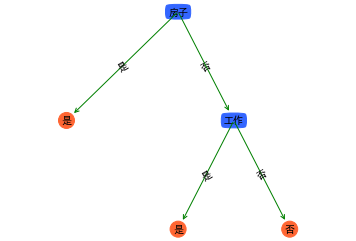

In [18]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题
##################################

# 绘制决策树
createPlot(myTree)